# LFW Clustering with RetinaFace + ArcFace

## 0. Setup

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import cv2
from insightface.app import FaceAnalysis
from tqdm import tqdm
import pandas as pd

## 1. Load LFW dataset

In [8]:
lfw = fetch_lfw_people(min_faces_per_person=10, resize=0.5) #min_faces_per_person=10 to ensure enough samples per identity, resize=0.5 to reduce image size for faster processing
images = lfw.images
labels = lfw.target
label_names = lfw.target_names
print(f"Images shape: {images.shape}, Identities: {len(np.unique(labels))}")

Images shape: (4324, 62, 47), Identities: 158


## 2. Initialize Face Detection + Embeddings

In [9]:
app = FaceAnalysis(name="buffalo_l")  #arcface
app.prepare(ctx_id=0, det_size=(160,160))  #app.prepare initializes the model for face detection and embedding extraction

def detect_and_embed(img):
    img_uint8 = (img * 255).astype(np.uint8) #convert image to uint8
    if len(img_uint8.shape) == 2: #if grayscale image
        img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR) #convert to BGR
    else:
        img_bgr = img_uint8 #image is already 3-channel
    faces = app.get(img_bgr)  #app.get performs face detection
    if len(faces) == 0: #no faces detected
        return None
    return faces[0].embedding #return the embedding of the first detected face

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:02<00:00, 94786.45KB/s]
/usr/local/lib/python3.12/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (160, 160)


## 3. Extract embeddings

In [10]:
embeddings = []
valid_labels = []
for img, lbl in tqdm(zip(images, labels), total=len(images), desc="Processing images"): #for each image and label
    emb = detect_and_embed(img) #detect face and extract embedding
    if emb is not None: #if embedding is valid, store emb & label
        embeddings.append(emb)
        valid_labels.append(lbl)

embeddings = np.stack(embeddings)
valid_labels = np.array(valid_labels)
print(f"Extracted embeddings shape: {embeddings.shape}")

Processing images: 100%|██████████| 4324/4324 [43:19<00:00,  1.66it/s]

Extracted embeddings shape: (4324, 512)


In [11]:
#save data to csv
embeddings_df = pd.DataFrame(embeddings)
embeddings_df['label'] = valid_labels
embeddings_df.to_csv('lfw_face_embeddings.csv', index=False)
print("Embeddings and valid_labels saved to 'lfw_face_embeddings.csv'")

Embeddings and valid_labels saved to 'lfw_face_embeddings.csv'


## 4. Cluster by identity

In [77]:
filtered_labels = []
for lbl in np.unique(valid_labels):
    count = np.sum(valid_labels == lbl)
    if 10 <= count <= 15:
        filtered_labels.append(lbl)
print(f"Filtered number of identities: {len(filtered_labels)}")
print(f"Images shape: {images.shape}")
mask = np.isin(valid_labels, filtered_labels)
embeddings = embeddings[mask]
valid_labels = valid_labels[mask]

Filtered number of identities: 73
Images shape: (4324, 62, 47)


In [78]:
identity_clusters = {lbl: embeddings[valid_labels==lbl] for lbl in np.unique(valid_labels)}

In [79]:
cluster_stats = {}
for lbl, cluster in identity_clusters.items():
    centroid = cluster.mean(axis=0)
    distances = np.linalg.norm(cluster - centroid, axis=1)
    cluster_stats[label_names[lbl]] = {
        "centroid": centroid,
        "radius": distances.max(),
        "dispersion": distances.std(),
        "num_images": len(cluster)
    }

In [80]:
print(cluster_stats)

{np.str_('Adrien Brody'): {'centroid': array([-8.10777128e-01,  1.50526190e+00,  6.70588791e-01,  9.05916393e-01,
       -1.79517210e+00,  1.81159854e-01,  5.92670262e-01, -2.05355096e+00,
       -1.17217338e+00, -1.55325636e-01, -6.41402602e-01,  3.57359558e-01,
       -6.49259165e-02, -5.38696587e-01,  1.88334063e-01,  1.06409304e-01,
       -3.29386860e-01, -1.90006956e-01,  3.08254242e+00, -7.35568464e-01,
       -7.81848431e-01,  1.47691572e+00,  3.88636678e-01, -5.49625814e-01,
        2.58153796e-01, -1.41833350e-01,  6.29427373e-01, -8.35412264e-01,
        2.96571732e-01,  1.85984537e-01,  6.09561265e-01,  4.34661984e-01,
        1.02432442e+00, -1.65360653e+00,  7.96705306e-01, -3.92024964e-01,
        1.25474168e-03, -5.44471920e-01, -4.47884411e-01,  4.64975089e-01,
        4.66343641e-01,  1.45768976e+00,  9.00721252e-01, -3.61324340e-01,
       -6.20486252e-02,  4.34991509e-01,  4.88647342e-01,  5.50662279e-01,
        1.16648518e-01, -6.89052999e-01,  1.38856852e+00,  1.

## 5. Intrinsic dimensionality

In [81]:
intrinsic_dim = {}
for lbl, cluster in identity_clusters.items():
    if len(cluster) < 2: #do nothing
        continue
    pca = PCA(n_components=min(len(cluster), cluster.shape[1])) #min(len cluster and 512D)
    pca.fit(cluster)
    intrinsic_dim[label_names[lbl]] = np.sum(pca.explained_variance_ratio_ > 0.01)

- pca.explanined_variance_ratio_: vector size min(n,D) contains the fraction of variance explained for each principal component.
- .>0.01: PC explains more than 1%
- sum the ones that are >0.01, and those are the intrinsic dimension

In [82]:
#intrinsic dimensions by identity
for identity, dim in intrinsic_dim.items():
    print(f"Identity: {identity}, Intrinsic Dimension: {dim}")

Identity: Adrien Brody, Intrinsic Dimension: 11
Identity: Andy Roddick, Intrinsic Dimension: 14
Identity: Ann Veneman, Intrinsic Dimension: 10
Identity: Anna Kournikova, Intrinsic Dimension: 11
Identity: Ari Fleischer, Intrinsic Dimension: 11
Identity: Bill McBride, Intrinsic Dimension: 9
Identity: Bill Simon, Intrinsic Dimension: 14
Identity: Britney Spears, Intrinsic Dimension: 13
Identity: Catherine Zeta-Jones, Intrinsic Dimension: 10
Identity: Charles Moose, Intrinsic Dimension: 12
Identity: Condoleezza Rice, Intrinsic Dimension: 10
Identity: David Nalbandian, Intrinsic Dimension: 13
Identity: Dick Cheney, Intrinsic Dimension: 13
Identity: Dominique de Villepin, Intrinsic Dimension: 14
Identity: Edmund Stoiber, Intrinsic Dimension: 12
Identity: Eduardo Duhalde, Intrinsic Dimension: 13
Identity: George HW Bush, Intrinsic Dimension: 12
Identity: Gonzalo Sanchez de Lozada, Intrinsic Dimension: 11
Identity: Gordon Brown, Intrinsic Dimension: 12
Identity: Harrison Ford, Intrinsic Dimens

Plot with initials

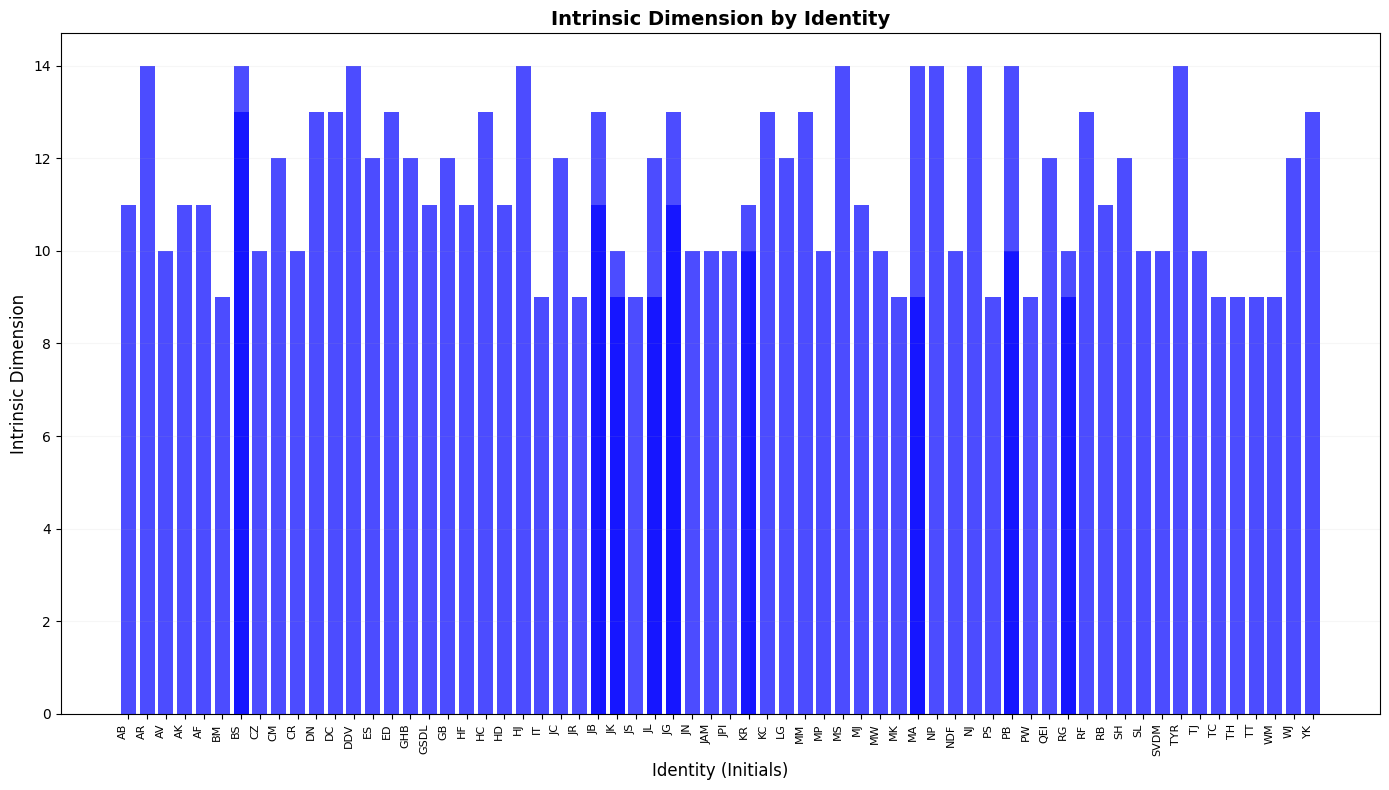

In [83]:
plt.figure(figsize=(14, 8))
identities = list(intrinsic_dim.keys())
dimensions = list(intrinsic_dim.values())
initials = [''.join([part[0].upper() for part in name.split()]) for name in identities]

plt.bar(initials, dimensions, color='blue', alpha=0.7)
plt.title('Intrinsic Dimension by Identity', fontsize=14, fontweight='bold')
plt.xlabel('Identity (Initials)', fontsize=12)
plt.ylabel('Intrinsic Dimension', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.grid(True, alpha=0.1, axis='y')
plt.tight_layout()
plt.show()

Plot by the name

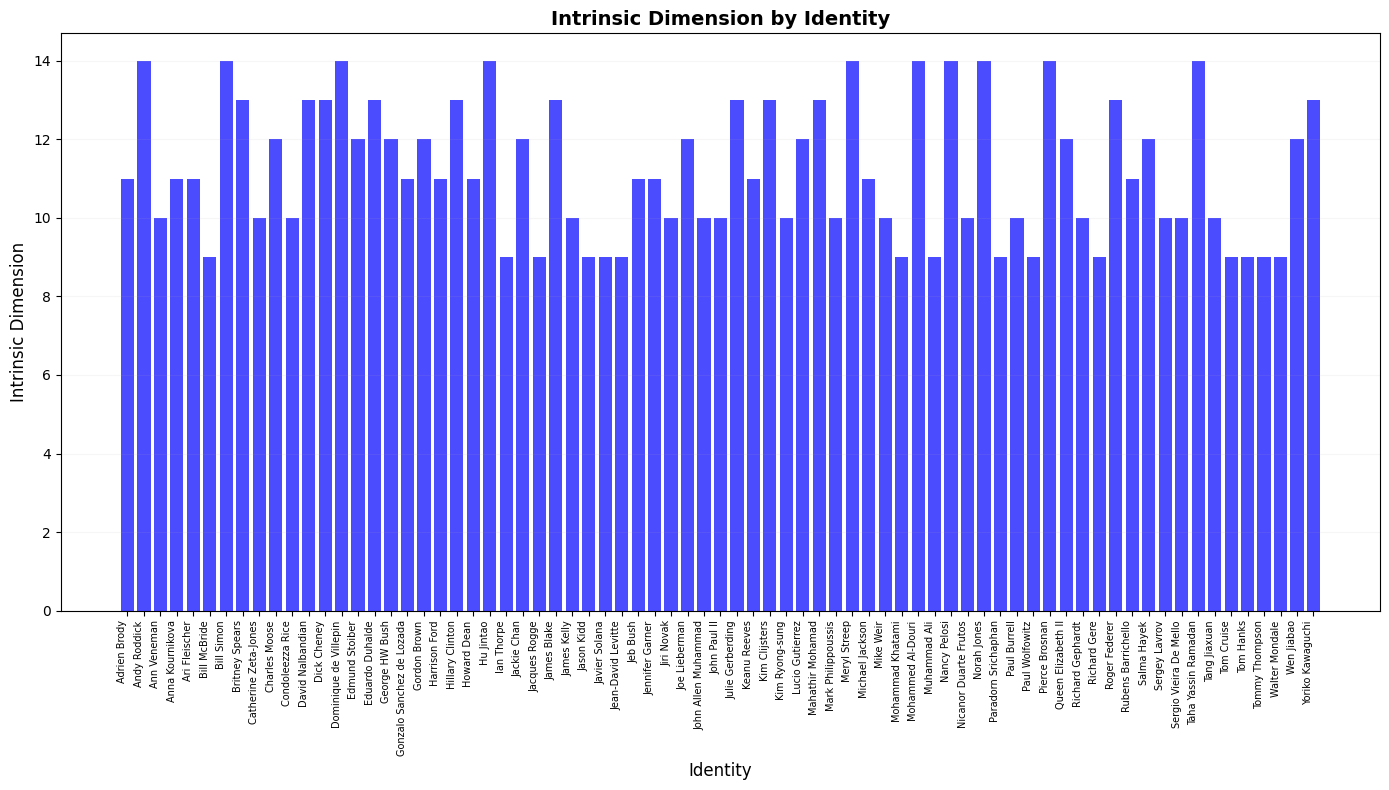

In [84]:
plt.figure(figsize=(14, 8))
identities = list(intrinsic_dim.keys())
dimensions = list(intrinsic_dim.values())

plt.bar(identities, dimensions, color='blue', alpha=0.7)
plt.title('Intrinsic Dimension by Identity', fontsize=14, fontweight='bold')
plt.xlabel('Identity', fontsize=12)
plt.ylabel('Intrinsic Dimension', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=7)
plt.grid(True, alpha=0.1, axis='y')
plt.tight_layout()
plt.show()

## 6. Visualization Clusters

Number of clusters: 73


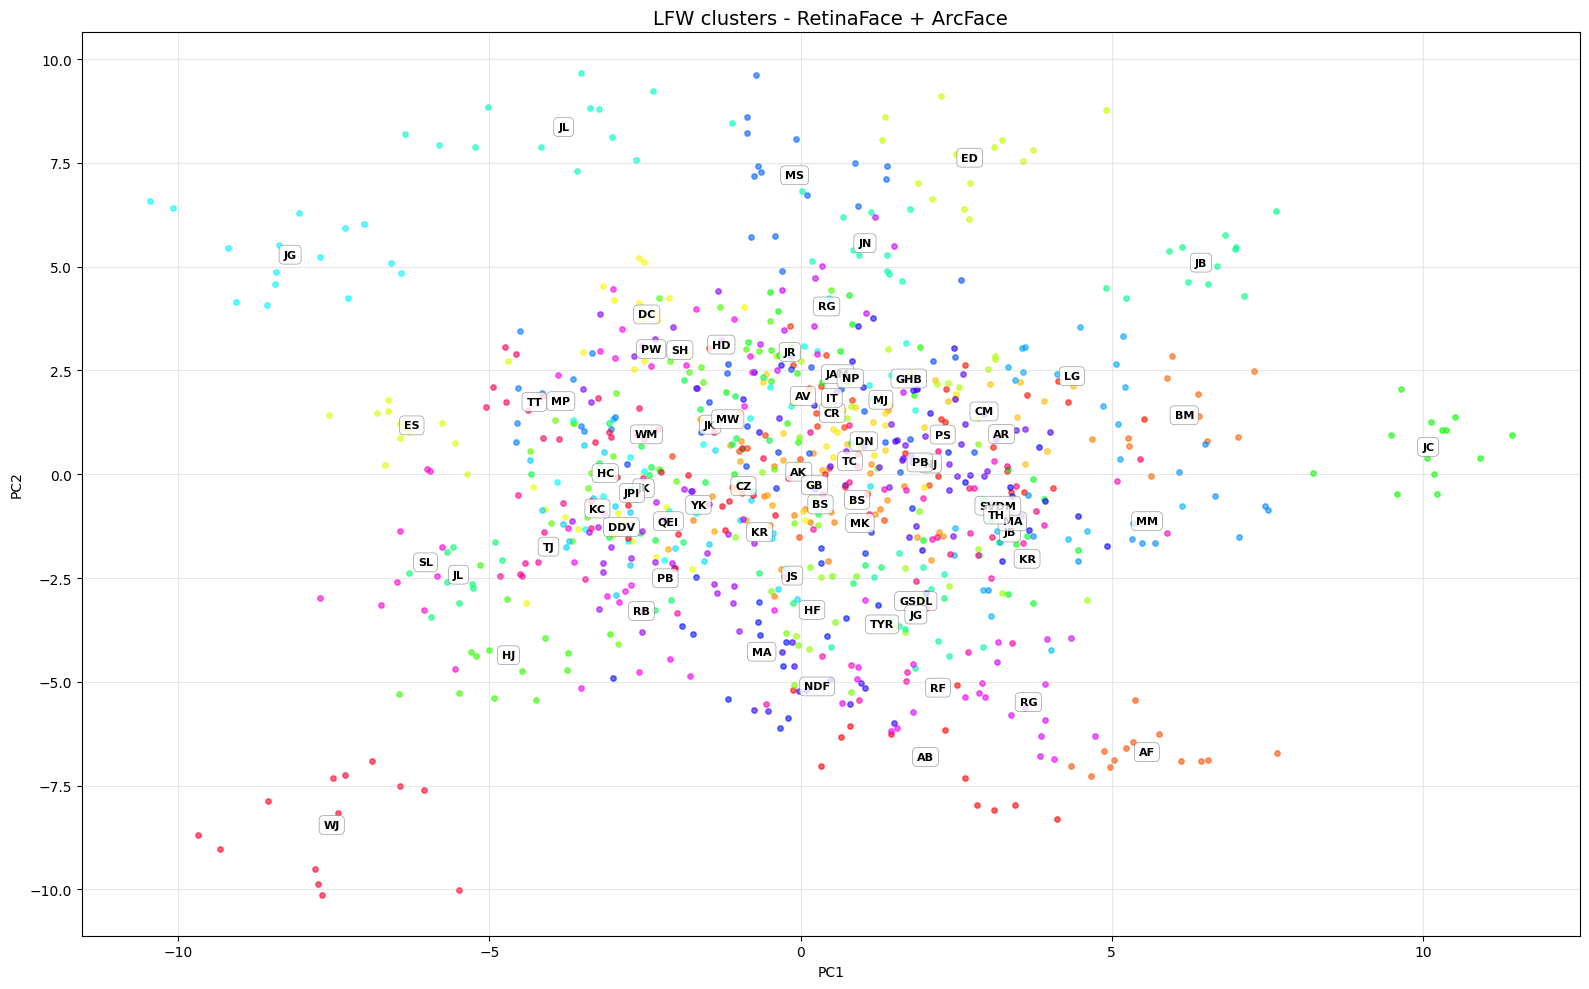

In [85]:
pca_2d = PCA(n_components=2)
emb_2d = pca_2d.fit_transform(embeddings)
centroids_2d = pca_2d.transform(np.array([cluster_stats[name]['centroid'] for name in cluster_stats.keys()]))

num_clusters = len(np.unique(valid_labels))
print(f"Number of clusters: {num_clusters}")
colors = plt.cm.hsv(np.linspace(0, 1, num_clusters))

plt.figure(figsize=(16, 10))
for idx, lbl in enumerate(np.unique(valid_labels)):
    cluster_points = emb_2d[valid_labels==lbl]
    plt.scatter(cluster_points[:,0], cluster_points[:,1], s=15, alpha=0.6, color=colors[idx]) #cluster_points[:,0], cluster_points[:,1] = x and y coordinates
    centroid_2d = cluster_points.mean(axis=0) #centroid in 2d

    name_parts = label_names[lbl].split() #name initials
    initials = ''.join([part[0].upper() for part in name_parts])
    plt.text(centroid_2d[0], centroid_2d[1], initials, fontsize=8, ha='center', va='center',bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5),fontweight='bold')

plt.title("LFW clusters - RetinaFace + ArcFace", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


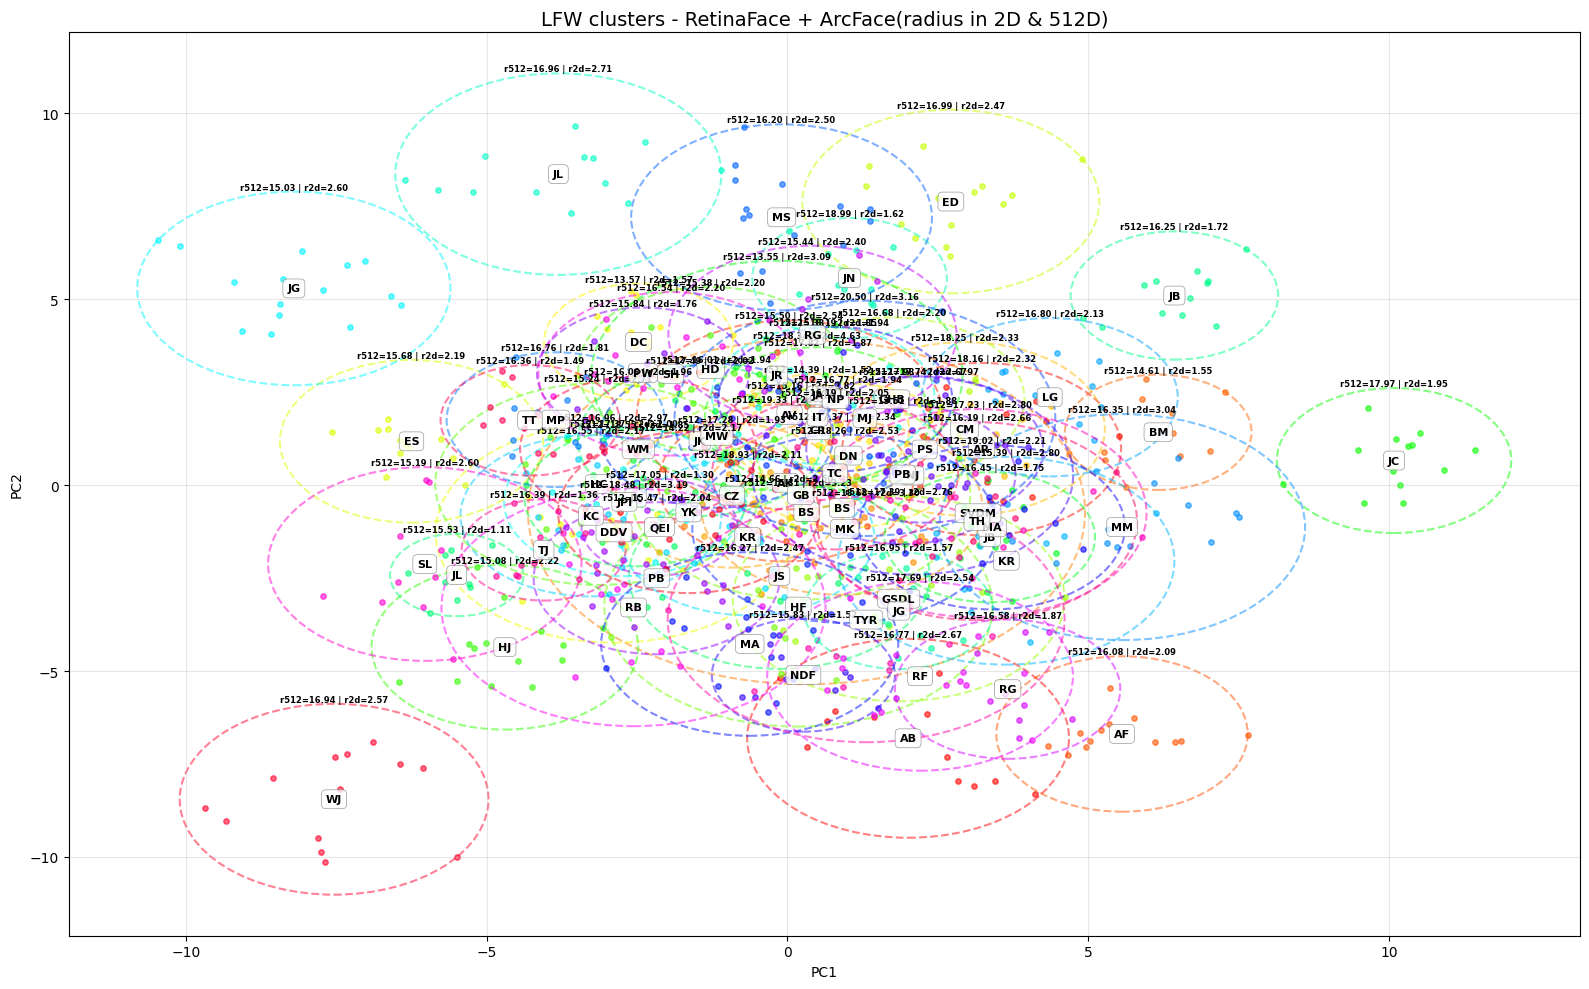

In [86]:
#same figure but with radius circles
plt.figure(figsize=(16, 10))
for idx, lbl in enumerate(np.unique(valid_labels)):
    cluster_points = emb_2d[valid_labels==lbl]
    plt.scatter(cluster_points[:,0], cluster_points[:,1], s=15, alpha=0.6, color=colors[idx])
    identity_name = label_names[lbl]
    centroid_2d = cluster_points.mean(axis=0) #centroid cluster in 2D space

    distances_2d = np.linalg.norm(cluster_points - centroid_2d, axis=1) #max radius in 2D
    radius_2d = distances_2d.max()
    radius_512d = cluster_stats[identity_name]['radius']# radius in original 512D space

    circle = plt.Circle(centroid_2d, radius_2d, color=colors[idx], fill=False, linewidth=1.5, linestyle='--', alpha=0.5) #circle
    plt.gca().add_patch(circle)

    name_parts = identity_name.split()#name initials
    initials = ''.join([part[0].upper() for part in name_parts])
    plt.text(centroid_2d[0], centroid_2d[1], initials, fontsize=8, ha='center', va='center',bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5),fontweight='bold')

    #show radius in 512D and 2D PCA
    plt.text(centroid_2d[0], centroid_2d[1] + radius_2d, f'r512={radius_512d:.2f} | r2d={radius_2d:.2f}', fontsize=6, ha='center', va='bottom', color="black", fontweight='bold')

plt.title("LFW clusters - RetinaFace + ArcFace(radius in 2D & 512D)", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Cosine similarity between clusters

In [87]:
similarities = []
identity_pairs = []

for lbl1, lbl2 in zip(np.unique(valid_labels)[:-1], np.unique(valid_labels)[1:]):
    c1 = cluster_stats[label_names[lbl1]]['centroid']
    c2 = cluster_stats[label_names[lbl2]]['centroid']
    sim = cosine_similarity(c1.reshape(1,-1), c2.reshape(1,-1))[0,0]
    similarities.append(sim)
    identity_pairs.append(f"{label_names[lbl1][:3]} vs {label_names[lbl2][:3]}")
    print(f"Cosine similarity {label_names[lbl1]} vs {label_names[lbl2]}: {sim}")

Cosine similarity Adrien Brody vs Andy Roddick: 0.012591581791639328
Cosine similarity Andy Roddick vs Ann Veneman: 0.022342296317219734
Cosine similarity Ann Veneman vs Anna Kournikova: 0.20611730217933655
Cosine similarity Anna Kournikova vs Ari Fleischer: 0.10760828852653503
Cosine similarity Ari Fleischer vs Bill McBride: 0.0959300845861435
Cosine similarity Bill McBride vs Bill Simon: 0.17490625381469727
Cosine similarity Bill Simon vs Britney Spears: 0.06331650912761688
Cosine similarity Britney Spears vs Catherine Zeta-Jones: -0.007165134884417057
Cosine similarity Catherine Zeta-Jones vs Charles Moose: -0.007600579410791397
Cosine similarity Charles Moose vs Condoleezza Rice: -0.02056889794766903
Cosine similarity Condoleezza Rice vs David Nalbandian: 0.0009904834441840649
Cosine similarity David Nalbandian vs Dick Cheney: -0.010200850665569305
Cosine similarity Dick Cheney vs Dominique de Villepin: -0.049507562071084976
Cosine similarity Dominique de Villepin vs Edmund Stoiber

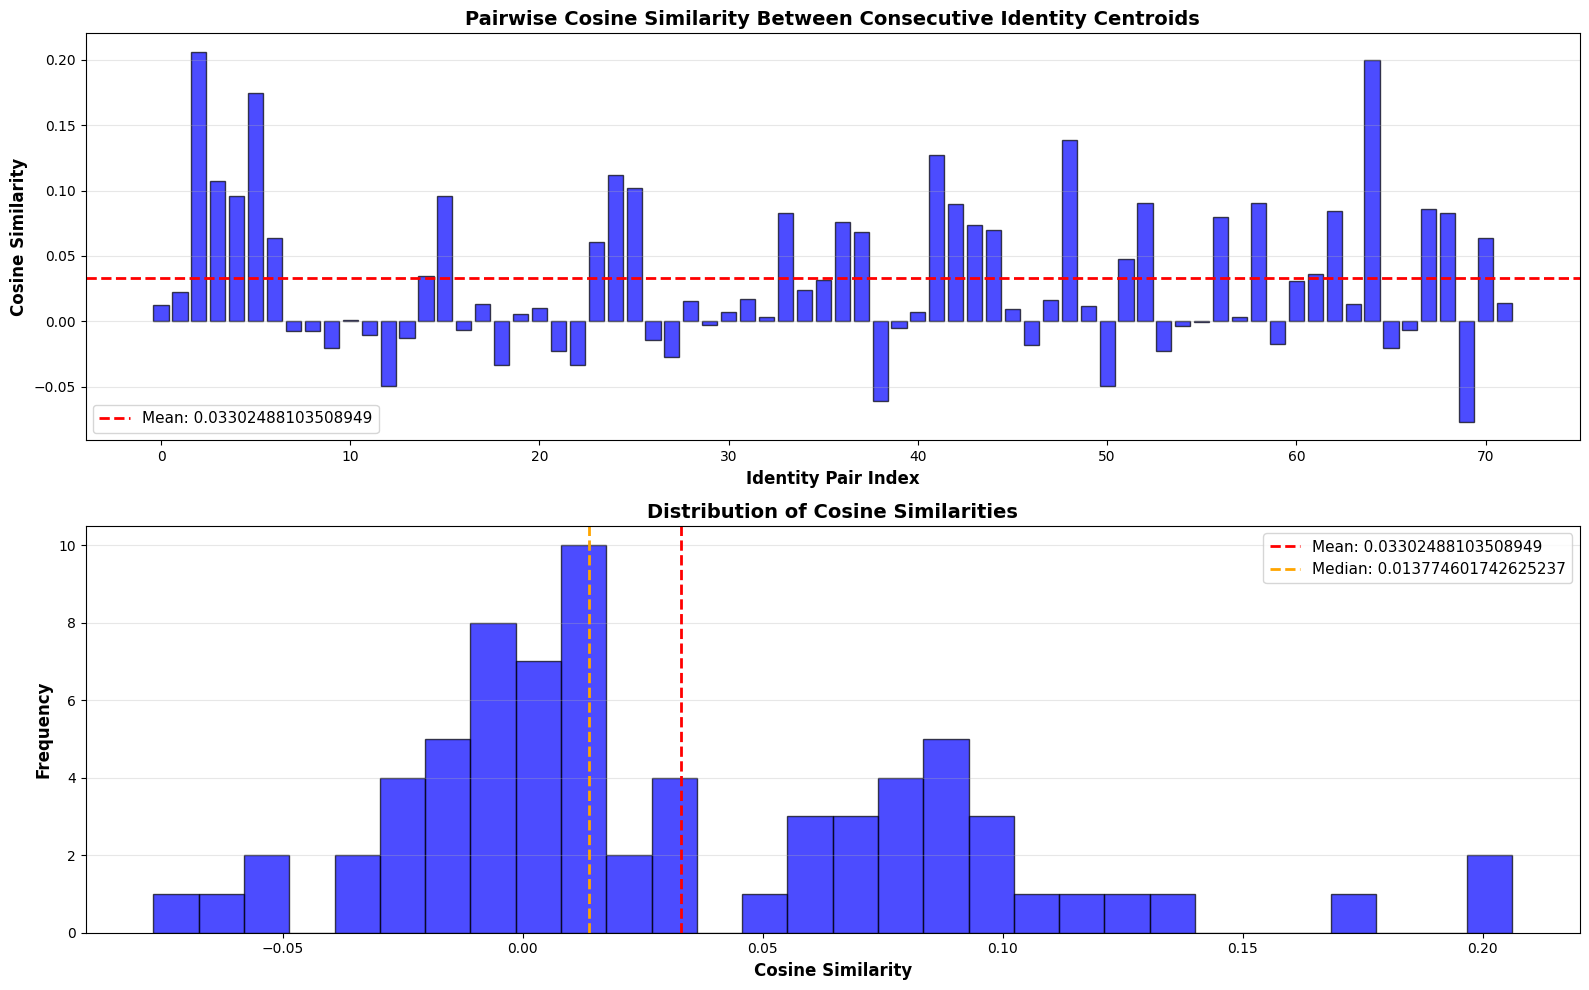

COSINE SIMILARITY STATISTICS (Consecutive Pairs):
Mean similarity: 0.03302488103508949
Median similarity: 0.013774601742625237
Std deviation: 0.058337222784757614
Min similarity: -0.07689718157052994
Max similarity: 0.20611730217933655


In [88]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

#cosine similarities
axes[0].bar(range(len(similarities)), similarities, color='blue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=np.mean(similarities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(similarities)}')
axes[0].set_xlabel('Identity Pair Index', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cosine Similarity', fontsize=12, fontweight='bold')
axes[0].set_title('Pairwise Cosine Similarity Between Consecutive Identity Centroids', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
#distribution histogram
axes[1].hist(similarities, bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[1].axvline(x=np.mean(similarities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(similarities)}')
axes[1].axvline(x=np.median(similarities), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(similarities)}')
axes[1].set_xlabel('Cosine Similarity', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Cosine Similarities', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

#stats
print("="*70)
print("COSINE SIMILARITY STATISTICS (Consecutive Pairs):")
print("="*70)
print(f"Mean similarity: {np.mean(similarities)}")
print(f"Median similarity: {np.median(similarities)}")
print(f"Std deviation: {np.std(similarities)}")
print(f"Min similarity: {np.min(similarities)}")
print(f"Max similarity: {np.max(similarities)}")

## 8. Analyze cluster stats

In [89]:
#cluster data to DataFrame
cluster_stats_df = pd.DataFrame.from_dict(cluster_stats, orient='index')
print(cluster_stats_df.head())

                                                          centroid     radius  \
Adrien Brody     [-0.8107771, 1.5052619, 0.6705888, 0.9059164, ...  16.773529   
Andy Roddick     [0.43716955, -0.25106147, 1.008508, -1.1221188...  18.158503   
Ann Veneman      [0.104856424, 1.3507495, 0.22876345, -0.045931...  15.502363   
Anna Kournikova  [0.66348547, 0.3227856, -0.49909735, 0.6200939...  19.328138   
Ari Fleischer    [0.16598773, 1.2778049, -0.03781186, 0.1252957...  16.081121   

                 dispersion  num_images  
Adrien Brody       1.393790          12  
Andy Roddick       1.158396          15  
Ann Veneman        1.295351          11  
Anna Kournikova    1.251229          12  
Ari Fleischer      1.345920          13  


In [90]:
intrinsic_dim_df = pd.DataFrame.from_dict(intrinsic_dim, orient='index', columns=['intrinsic_dimension'])
merged_df = intrinsic_dim_df.merge(cluster_stats_df, left_index=True, right_index=True)
print("Merged DataFrame created successfully")
print(merged_df.head())

Merged DataFrame created successfully
                 intrinsic_dimension  \
Adrien Brody                      11   
Andy Roddick                      14   
Ann Veneman                       10   
Anna Kournikova                   11   
Ari Fleischer                     11   

                                                          centroid     radius  \
Adrien Brody     [-0.8107771, 1.5052619, 0.6705888, 0.9059164, ...  16.773529   
Andy Roddick     [0.43716955, -0.25106147, 1.008508, -1.1221188...  18.158503   
Ann Veneman      [0.104856424, 1.3507495, 0.22876345, -0.045931...  15.502363   
Anna Kournikova  [0.66348547, 0.3227856, -0.49909735, 0.6200939...  19.328138   
Ari Fleischer    [0.16598773, 1.2778049, -0.03781186, 0.1252957...  16.081121   

                 dispersion  num_images  
Adrien Brody       1.393790          12  
Andy Roddick       1.158396          15  
Ann Veneman        1.295351          11  
Anna Kournikova    1.251229          12  
Ari Fleischer      1.345

In [91]:
print("Summary Statistics for Merged DataFrame:")
print(merged_df[['intrinsic_dimension', 'radius', 'dispersion', 'num_images']].describe())

Summary Statistics for Merged DataFrame:
       intrinsic_dimension     radius  dispersion  num_images
count            73.000000  73.000000   73.000000   73.000000
mean             11.219178  16.603397    1.499972   12.246575
std               1.734027   1.437964    0.336863    1.754208
min               9.000000  13.514213    0.703262   10.000000
25%              10.000000  15.502363    1.284000   11.000000
50%              11.000000  16.551018    1.426106   12.000000
75%              13.000000  17.493803    1.685850   14.000000
max              14.000000  20.495100    2.647965   15.000000


In [92]:
print("\nIdentities with most consistent face embeddings (smallest radius):")
print(cluster_stats_df.sort_values(by='radius', ascending=True).head())

print("\nIdentities with least consistent face embeddings (largest radius):")
print(cluster_stats_df.sort_values(by='radius', ascending=False).head())

print("\nIdentities with least dispersed embeddings (smallest dispersion):")
print(cluster_stats_df.sort_values(by='dispersion', ascending=True).head())

print("\nIdentities with most dispersed embeddings (largest dispersion):")
print(cluster_stats_df.sort_values(by='dispersion', ascending=False).head())

print("\nIndividuals with the most images:")
print(cluster_stats_df.sort_values(by='num_images', ascending=False).head())


Identities with most consistent face embeddings (smallest radius):
                                                           centroid  \
Paul Burrell      [-0.090826005, 0.5141508, -1.30118, 0.6041637,...   
Jacques Rogge     [0.2698771, 0.5046526, 0.26977342, -1.5241728,...   
Dick Cheney       [0.6181472, 0.0007442747, -0.10075232, -0.3234...   
Yoriko Kawaguchi  [-1.1094157, 0.027234389, -0.3773158, 1.097761...   
Condoleezza Rice  [-0.8874872, -0.119344495, 0.0251702, -0.80404...   

                     radius  dispersion  num_images  
Paul Burrell      13.514213    1.521168          11  
Jacques Rogge     13.552886    1.280454          10  
Dick Cheney       13.570552    1.156209          14  
Yoriko Kawaguchi  14.220515    1.134910          14  
Condoleezza Rice  14.390482    0.703262          11  

Identities with least consistent face embeddings (largest radius):
                                                          centroid     radius  \
Michael Jackson  [0.59904164, -1

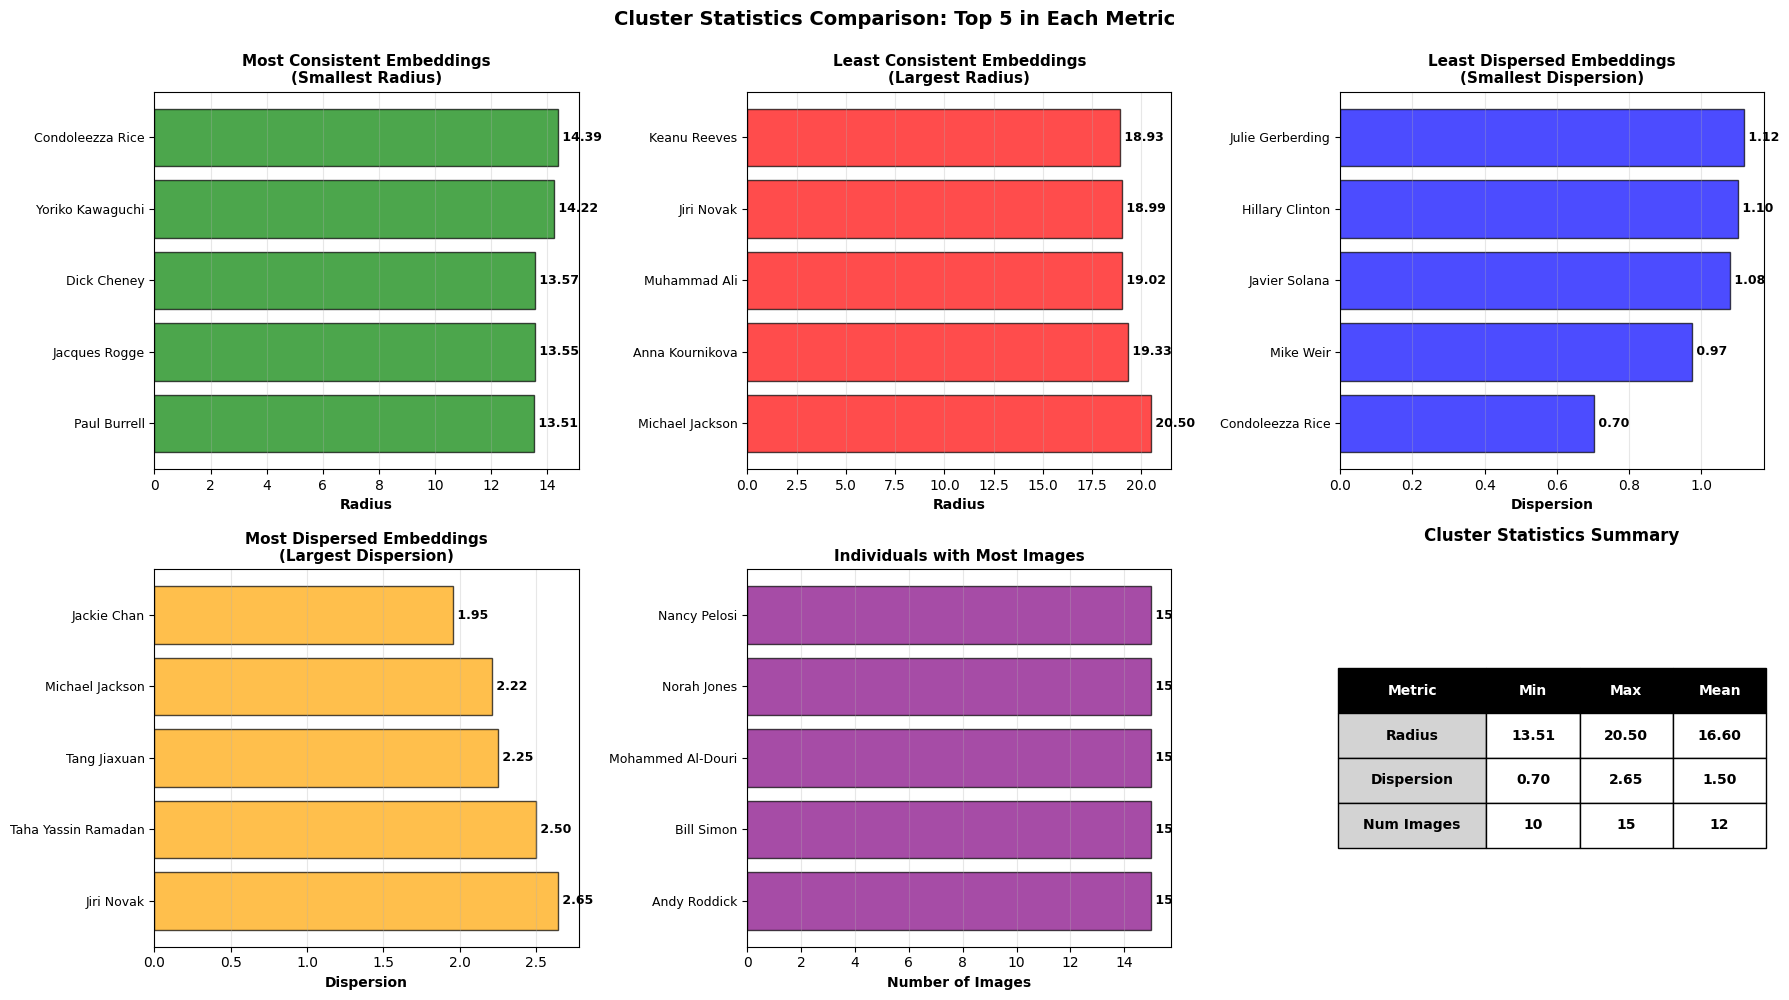

In [93]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

#smallest radius (most consistent)
smallest_radius = cluster_stats_df.sort_values(by='radius', ascending=True).head()
axes[0, 0].barh(range(len(smallest_radius)), smallest_radius['radius'], color='green', alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(smallest_radius)))
axes[0, 0].set_yticklabels(smallest_radius.index, fontsize=9)
axes[0, 0].set_xlabel('Radius', fontweight='bold')
axes[0, 0].set_title('Most Consistent Embeddings\n(Smallest Radius)', fontweight='bold', fontsize=11)
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(smallest_radius['radius']):
    axes[0, 0].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#largest radius (least consistent)
largest_radius = cluster_stats_df.sort_values(by='radius', ascending=False).head()
axes[0, 1].barh(range(len(largest_radius)), largest_radius['radius'], color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(largest_radius)))
axes[0, 1].set_yticklabels(largest_radius.index, fontsize=9)
axes[0, 1].set_xlabel('Radius', fontweight='bold')
axes[0, 1].set_title('Least Consistent Embeddings\n(Largest Radius)', fontweight='bold', fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(largest_radius['radius']):
    axes[0, 1].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#smallest dispersion
smallest_dispersion = cluster_stats_df.sort_values(by='dispersion', ascending=True).head()
axes[0, 2].barh(range(len(smallest_dispersion)), smallest_dispersion['dispersion'], color='blue', alpha=0.7, edgecolor='black')
axes[0, 2].set_yticks(range(len(smallest_dispersion)))
axes[0, 2].set_yticklabels(smallest_dispersion.index, fontsize=9)
axes[0, 2].set_xlabel('Dispersion', fontweight='bold')
axes[0, 2].set_title('Least Dispersed Embeddings\n(Smallest Dispersion)', fontweight='bold', fontsize=11)
axes[0, 2].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(smallest_dispersion['dispersion']):
    axes[0, 2].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#largest dispersion
largest_dispersion = cluster_stats_df.sort_values(by='dispersion', ascending=False).head()
axes[1, 0].barh(range(len(largest_dispersion)), largest_dispersion['dispersion'], color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(len(largest_dispersion)))
axes[1, 0].set_yticklabels(largest_dispersion.index, fontsize=9)
axes[1, 0].set_xlabel('Dispersion', fontweight='bold')
axes[1, 0].set_title('Most Dispersed Embeddings\n(Largest Dispersion)', fontweight='bold', fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(largest_dispersion['dispersion']):
    axes[1, 0].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#images
most_images = cluster_stats_df.sort_values(by='num_images', ascending=False).head()
axes[1, 1].barh(range(len(most_images)), most_images['num_images'], color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(most_images)))
axes[1, 1].set_yticklabels(most_images.index, fontsize=9)
axes[1, 1].set_xlabel('Number of Images', fontweight='bold')
axes[1, 1].set_title('Individuals with Most Images', fontweight='bold', fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(most_images['num_images']):
    axes[1, 1].text(val, i, f' {int(val)}', va='center', fontweight='bold', fontsize=9)

#statistics table
axes[1, 2].axis('tight')
axes[1, 2].axis('off')
summary_data = [
    ['Metric', 'Min', 'Max', 'Mean'],
    ['Radius', f"{cluster_stats_df['radius'].min():.2f}", f"{cluster_stats_df['radius'].max():.2f}", f"{cluster_stats_df['radius'].mean():.2f}"],
    ['Dispersion', f"{cluster_stats_df['dispersion'].min():.2f}", f"{cluster_stats_df['dispersion'].max():.2f}", f"{cluster_stats_df['dispersion'].mean():.2f}"],
    ['Num Images', f"{int(cluster_stats_df['num_images'].min())}", f"{int(cluster_stats_df['num_images'].max())}", f"{int(cluster_stats_df['num_images'].mean())}"]
]
table = axes[1, 2].table(cellText=summary_data, cellLoc='center', loc='center', colWidths=[0.35, 0.22, 0.22, 0.22])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)
for i in range(4): #header
    table[(0, i)].set_facecolor('black')
    table[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, 4): #rows
    table[(i, 0)].set_facecolor('#D3D3D3')
    table[(i, 0)].set_text_props(weight='bold')
    for j in range(1, 4):
        table[(i, j)].set_facecolor('white' if i % 2 == 0 else 'white')
        table[(i, j)].set_text_props(weight='bold')
axes[1, 2].set_title('Cluster Statistics Summary', fontweight='bold', fontsize=12, pad=20)

plt.suptitle('Cluster Statistics Comparison: Top 5 in Each Metric', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

- **Smallest Radius:** small average distance of ther embeddings from their centroids = face embeddings are tightly clustered, so they have higher consistency across different imgs of the same person
- **Largest Radius:** largest average distance from their centroids. Face embeddings are more spread out, so they have less consistency or greater variation in their imgs
- **Smallest Dispersion:** so small deviation of distances from their centroids, so the variation in embedding consistency are very low
- **Largest Dispersion:** largest deviation of distances, so they have more variability in the consistency of their embeddings. High dispersion = wider range of conditions in the imgs (pose, light, expression...)
- **Most Images:** lead to larger radii or dispersion due to greater diversity

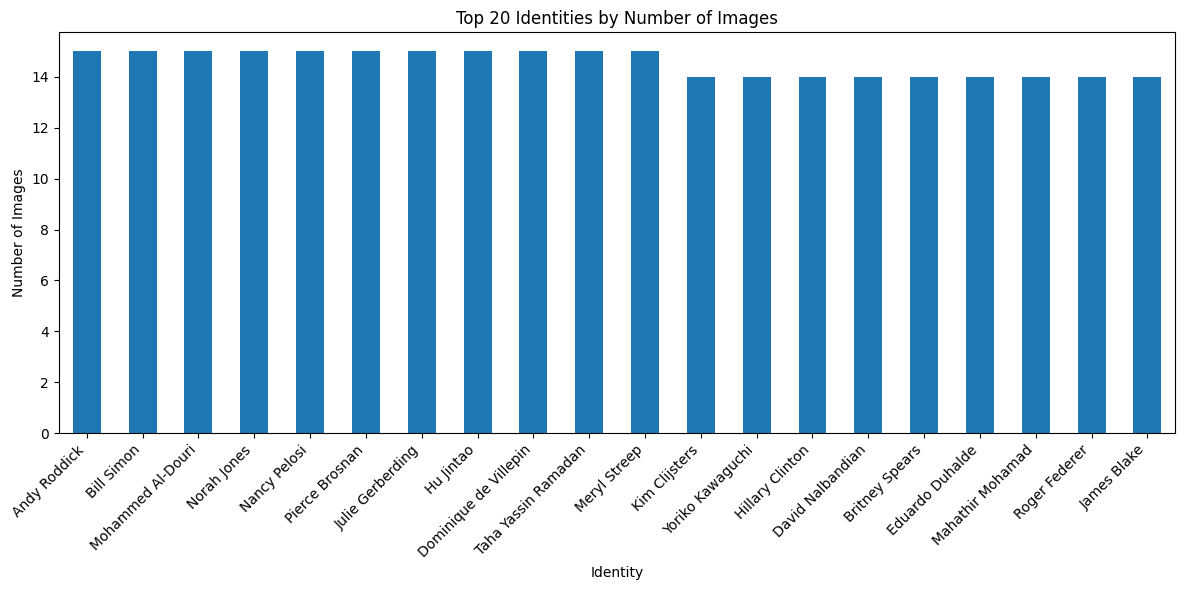

In [94]:
# number of imgs per identity bar plot
plt.figure(figsize=(12, 6))
top_n = 20  # Display top 20 identities
cluster_stats_df.sort_values(by='num_images', ascending=False).head(top_n)['num_images'].plot(kind='bar')
plt.title(f'Top {top_n} Identities by Number of Images')
plt.xlabel('Identity')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 9. Scatter Plot: Intrinsic Dimension vs. Cluster Dispersion

Higher intrinsic complexity in a person's image set often correlates with greater variability in the consistency of their face embeddings. The ArcFace model, while robust, shows signs of this increased challenge through higher dispersion values for identities with higher intrinsic dimensions.

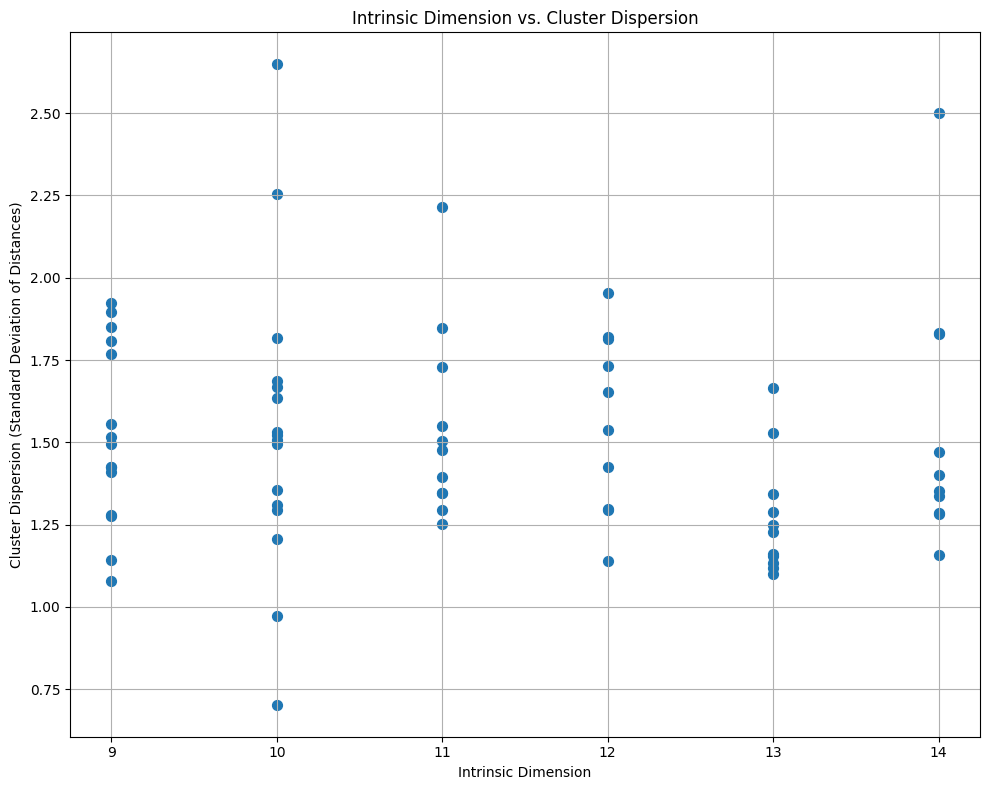

In [95]:
plt.figure(figsize=(10, 8))
plt.scatter(merged_df['intrinsic_dimension'], merged_df['dispersion'], s=50)
plt.title('Intrinsic Dimension vs. Cluster Dispersion')
plt.xlabel('Intrinsic Dimension')
plt.ylabel('Cluster Dispersion (Standard Deviation of Distances)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 10. Scatter Plot: Radius vs Dispersion


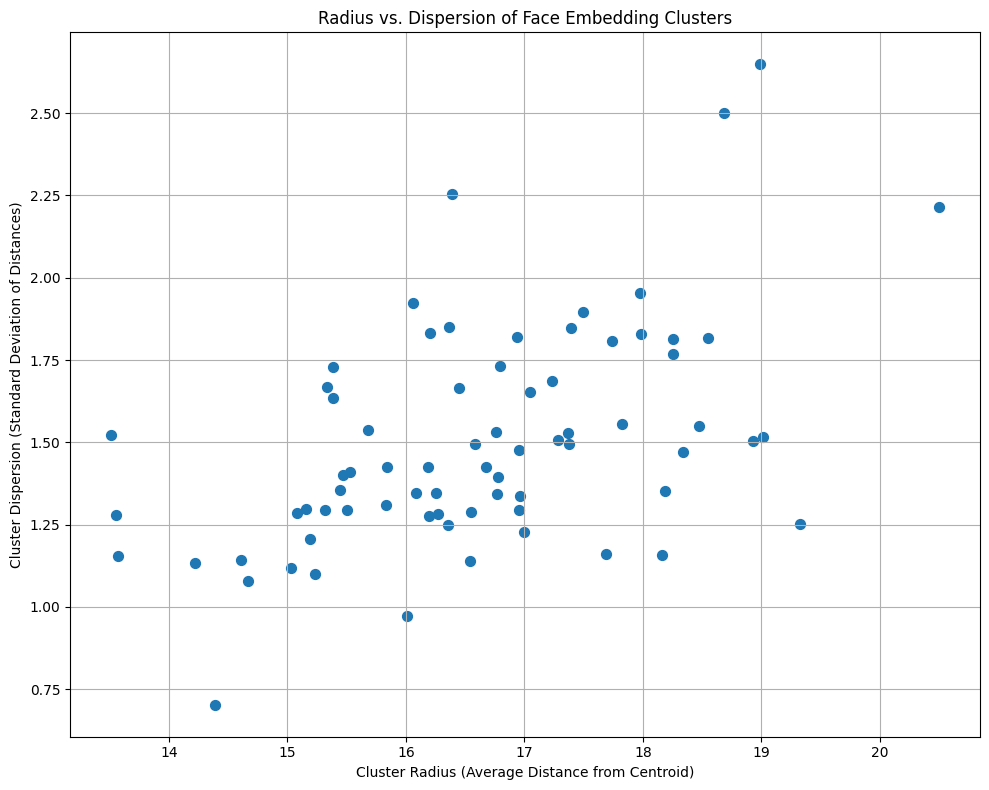

In [96]:
plt.figure(figsize=(10, 8))
plt.scatter(cluster_stats_df['radius'], cluster_stats_df['dispersion'], s=50)
plt.title('Radius vs. Dispersion of Face Embedding Clusters')
plt.xlabel('Cluster Radius (Average Distance from Centroid)')
plt.ylabel('Cluster Dispersion (Standard Deviation of Distances)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 11. Intrinsic Dimension of Clusters


In [97]:
intrinsic_dim_df = pd.DataFrame.from_dict(intrinsic_dim, orient='index', columns=['intrinsic_dimension'])
print("Intrinsic Dimensionality DataFrame Head:")
print(intrinsic_dim_df.head())

Intrinsic Dimensionality DataFrame Head:
                 intrinsic_dimension
Adrien Brody                      11
Andy Roddick                      14
Ann Veneman                       10
Anna Kournikova                   11
Ari Fleischer                     11


In [98]:
print("\nDescriptive Statistics for Intrinsic Dimensionality:")
print(intrinsic_dim_df['intrinsic_dimension'].describe())

print("\nIdentities with the 10 highest intrinsic dimensions:")
print(intrinsic_dim_df.sort_values(by='intrinsic_dimension', ascending=False).head(10))

print("\nIdentities with the 10 lowest intrinsic dimensions:")
print(intrinsic_dim_df.sort_values(by='intrinsic_dimension', ascending=True).head(10))


Descriptive Statistics for Intrinsic Dimensionality:
count    73.000000
mean     11.219178
std       1.734027
min       9.000000
25%      10.000000
50%      11.000000
75%      13.000000
max      14.000000
Name: intrinsic_dimension, dtype: float64

Identities with the 10 highest intrinsic dimensions:
                       intrinsic_dimension
Andy Roddick                            14
Bill Simon                              14
Mohammed Al-Douri                       14
Norah Jones                             14
Nancy Pelosi                            14
Pierce Brosnan                          14
Taha Yassin Ramadan                     14
Hu Jintao                               14
Dominique de Villepin                   14
Meryl Streep                            14

Identities with the 10 lowest intrinsic dimensions:
                     intrinsic_dimension
Bill McBride                           9
Jean-David Levitte                     9
Javier Solana                          9
Jason Ki


### Identities with High Intrinsic Dimensionality
exhibit a greater complexity or variability. This means that more principal components are needed to explain the variance within their respective clusters. This could be due to a wider range of poses, expressions, lighting conditions, or even image quality variations for these individuals in the LFW dataset.

### Identities with Low Intrinsic Dimensionality
their image clusters are less complex or more consistent. Fewer principal components are sufficient to capture the variance within their embeddings. This might imply that the images for these individuals are more uniform in terms of visual characteristics, or perhaps their facial features are inherently less variable across different images presented to the model.

In [99]:
top_10_high_intrinsic_dim_identities = intrinsic_dim_df.nlargest(10, 'intrinsic_dimension')
top_10_data = merged_df.loc[top_10_high_intrinsic_dim_identities.index][['intrinsic_dimension', 'radius', 'dispersion', 'num_images']]
print("\nMetrics for Identities with the 10 Highest Intrinsic Dimensions:")
print(top_10_data)


Metrics for Identities with the 10 Highest Intrinsic Dimensions:
                       intrinsic_dimension     radius  dispersion  num_images
Andy Roddick                            14  18.158503    1.158396          15
Bill Simon                              14  18.337446    1.469895          15
Dominique de Villepin                   14  16.962564    1.335676          15
Hu Jintao                               14  15.081648    1.284000          15
Meryl Streep                            14  16.203814    1.832260          15
Mohammed Al-Douri                       14  16.273712    1.281782          15
Nancy Pelosi                            14  18.187321    1.353781          15
Norah Jones                             14  17.979717    1.829035          15
Pierce Brosnan                          14  15.468116    1.399431          15
Taha Yassin Ramadan                     14  18.681789    2.501088          15


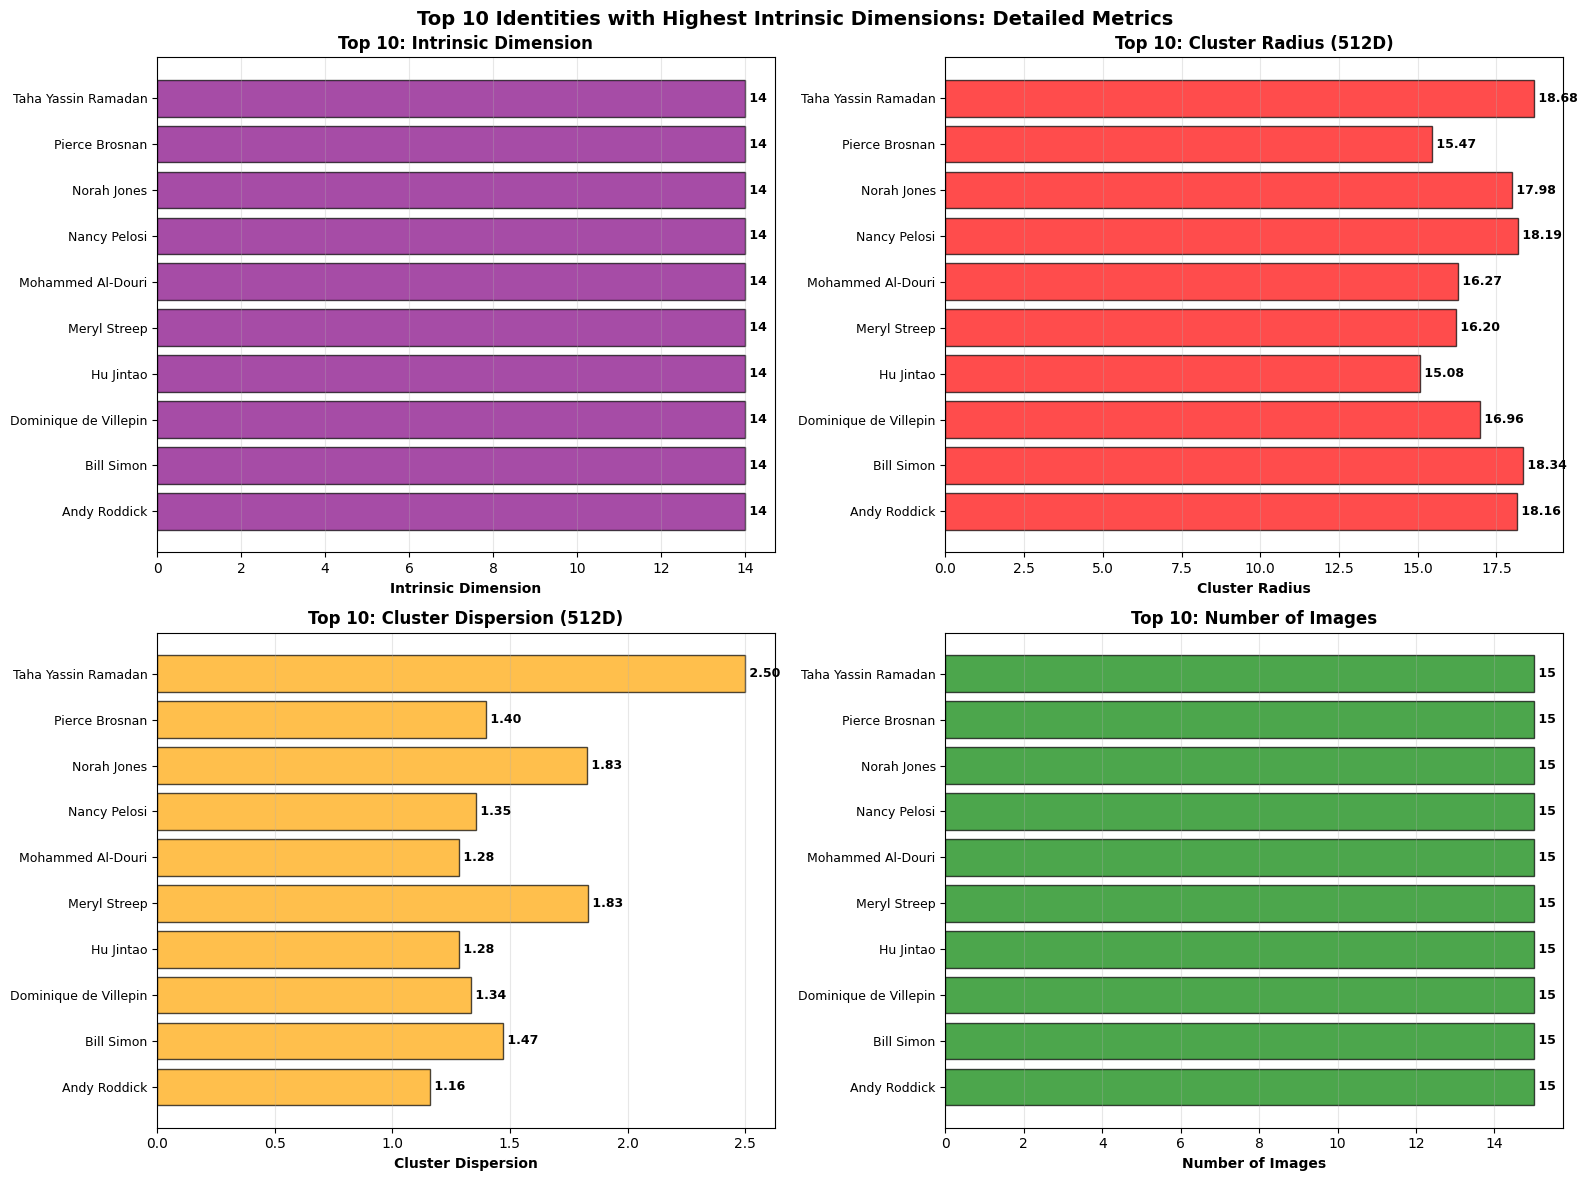

In [100]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#intrinsic Dimension
axes[0, 0].barh(range(len(top_10_data)), top_10_data['intrinsic_dimension'], color='purple', alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(top_10_data)))
axes[0, 0].set_yticklabels(top_10_data.index, fontsize=9)
axes[0, 0].set_xlabel('Intrinsic Dimension', fontweight='bold')
axes[0, 0].set_title('Top 10: Intrinsic Dimension', fontweight='bold', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['intrinsic_dimension']):
    axes[0, 0].text(val, i, f' {int(val)}', va='center', fontweight='bold', fontsize=9)

#radius
axes[0, 1].barh(range(len(top_10_data)), top_10_data['radius'], color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(top_10_data)))
axes[0, 1].set_yticklabels(top_10_data.index, fontsize=9)
axes[0, 1].set_xlabel('Cluster Radius', fontweight='bold')
axes[0, 1].set_title('Top 10: Cluster Radius (512D)', fontweight='bold', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['radius']):
    axes[0, 1].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#dispersion
axes[1, 0].barh(range(len(top_10_data)), top_10_data['dispersion'], color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(len(top_10_data)))
axes[1, 0].set_yticklabels(top_10_data.index, fontsize=9)
axes[1, 0].set_xlabel('Cluster Dispersion', fontweight='bold')
axes[1, 0].set_title('Top 10: Cluster Dispersion (512D)', fontweight='bold', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['dispersion']):
    axes[1, 0].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#number of Images
axes[1, 1].barh(range(len(top_10_data)), top_10_data['num_images'], color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_10_data)))
axes[1, 1].set_yticklabels(top_10_data.index, fontsize=9)
axes[1, 1].set_xlabel('Number of Images', fontweight='bold')
axes[1, 1].set_title('Top 10: Number of Images', fontweight='bold', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['num_images']):
    axes[1, 1].text(val, i, f' {int(val)}', va='center', fontweight='bold', fontsize=9)

plt.suptitle('Top 10 Identities with Highest Intrinsic Dimensions: Detailed Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

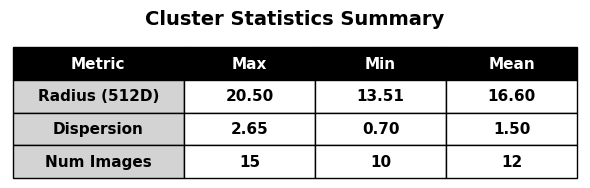

In [101]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('tight')
ax.axis('off')
summary_table_data = [
    ['Metric', 'Max', 'Min', 'Mean'],
    ['Radius (512D)', f"{merged_df['radius'].max():.2f}", f"{merged_df['radius'].min():.2f}", f"{merged_df['radius'].mean():.2f}"],
    ['Dispersion', f"{merged_df['dispersion'].max():.2f}", f"{merged_df['dispersion'].min():.2f}", f"{merged_df['dispersion'].mean():.2f}"],
    ['Num Images', f"{int(merged_df['num_images'].max())}", f"{int(merged_df['num_images'].min())}", f"{int(merged_df['num_images'].mean())}"]
]
table1 = ax.table(cellText=summary_table_data, cellLoc='center', loc='center', colWidths=[0.3, 0.23, 0.23, 0.23])
table1.auto_set_font_size(False)
table1.set_fontsize(11)
table1.scale(1, 2.5)
for i in range(4):
    table1[(0, i)].set_facecolor('black')
    table1[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, 4):
    table1[(i, 0)].set_facecolor('#D3D3D3')
    table1[(i, 0)].set_text_props(weight='bold')
    for j in range(1, 4):
        table1[(i, j)].set_facecolor('white')
        table1[(i, j)].set_text_props(weight='bold')
plt.title('Cluster Statistics Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

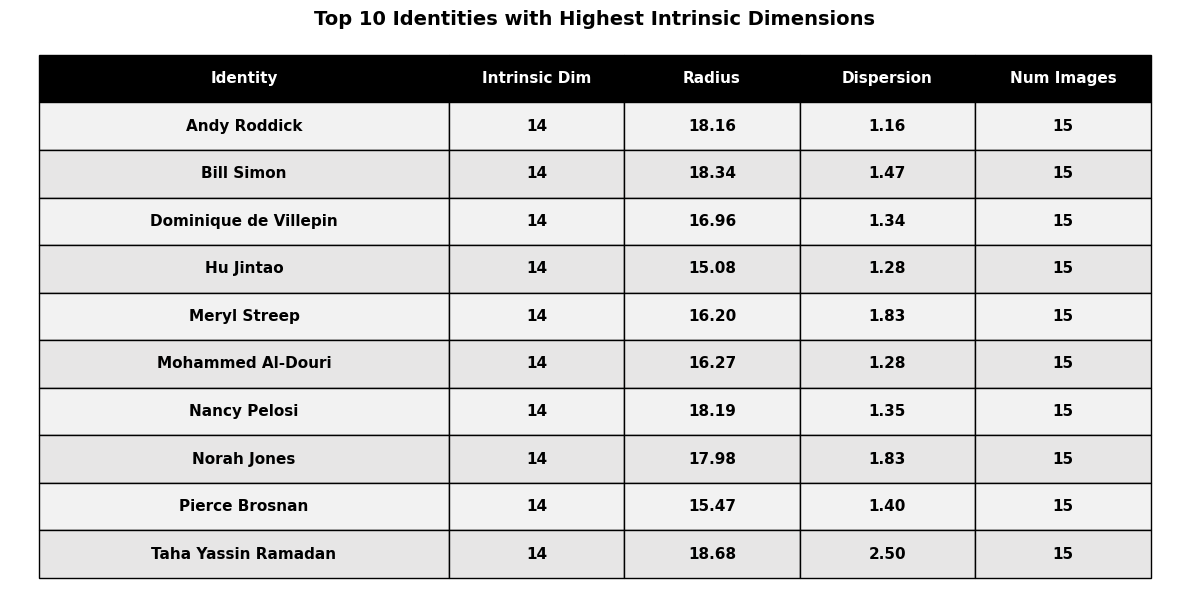

In [102]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table_data = [['Identity', 'Intrinsic Dim', 'Radius', 'Dispersion', 'Num Images']]
for identity, row in top_10_data.iterrows():
    table_data.append([
        identity,
        f"{int(row['intrinsic_dimension'])}",
        f"{row['radius']:.2f}",
        f"{row['dispersion']:.2f}",
        f"{int(row['num_images'])}"
    ])
table = ax.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.35, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

for i in range(5):
    table[(0, i)].set_facecolor('black')
    table[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, len(table_data)):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')
        else:
            table[(i, j)].set_facecolor('#F2F2F2')
        table[(i, j)].set_text_props(weight='bold')
plt.title('Top 10 Identities with Highest Intrinsic Dimensions', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 12. Scatter Plot: Radius and Number of Images


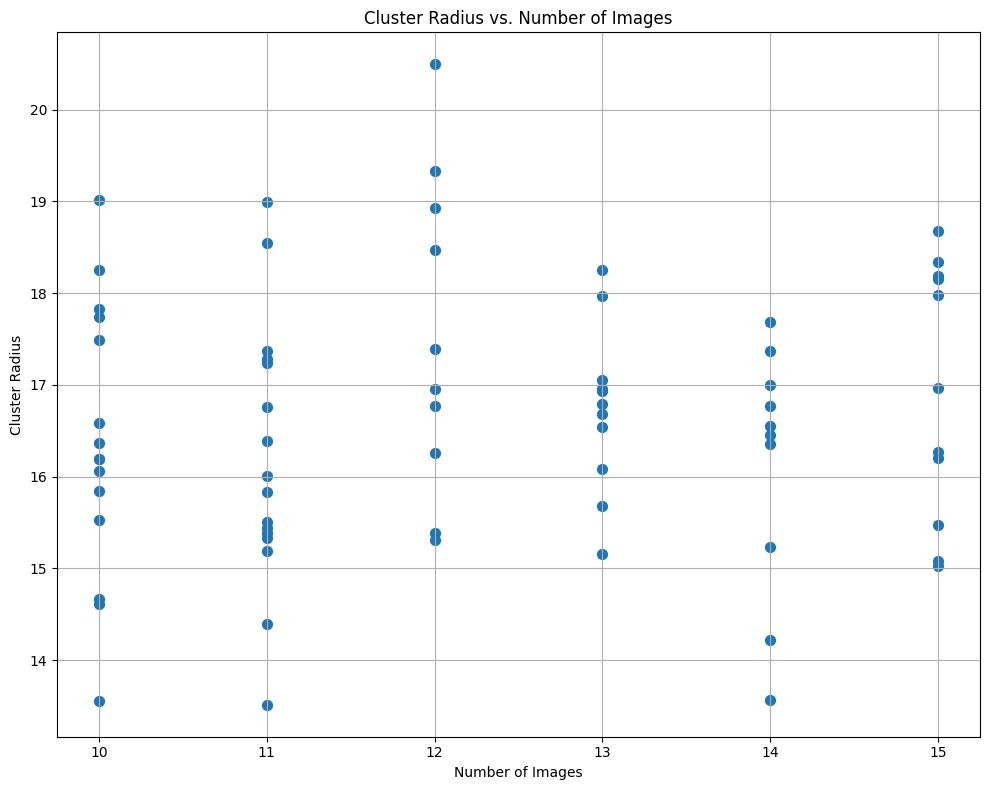

In [103]:
plt.figure(figsize=(10, 8))
plt.scatter(merged_df['num_images'], merged_df['radius'], s=50)
plt.title('Cluster Radius vs. Number of Images')
plt.xlabel('Number of Images')
plt.ylabel('Cluster Radius')
plt.grid(True)
plt.tight_layout()
plt.show()

No strong linear correlation between them


Even with few images some identites have very consistent embeddings, while others can be quite incosistent

